In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import dblquad
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

from dataloader import FastTensorDataLoader

# Poisson Point Processes

## Data Generation

In [2]:
def generate_poisson_points(kappa, scale, region):
    """
    Generate a Poisson Point Process in a 2D region based on intensity function.
    
    Parameters:
    - kappa (torch.Tensor): The intensity parameter (scalar or vector).
    - scale (torch.Tensor): The scale parameter (scalar or vector).
    - region (tuple): The spatial domain as ((xmin, xmax), (ymin, ymax)).
    - num_samples (int): Number of candidate points to sample for rejection sampling.
    
    Returns:
    - points (numpy.ndarray): The simulated points of the PPP.
    """
    (xmin, xmax), (ymin, ymax) = region

    area = (xmax - xmin) * (ymax - ymin)
    max_intensity = kappa * area  # Maximum value of intensity
    num_samples = np.random.poisson(lam=max_intensity)[0]

    x_candidates = np.random.uniform(xmin, xmax, size=num_samples)
    y_candidates = np.random.uniform(ymin, ymax, size=num_samples)
    candidates = torch.tensor(np.stack([x_candidates, y_candidates], axis=1), dtype=torch.float32)
    
    squared_norm = torch.sum(candidates**2, dim=-1)
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    
    uniform_samples = torch.rand(num_samples)  # Uniform samples for rejection
    acceptance_mask = uniform_samples < (intensity / kappa)
    
    accepted_points = candidates[acceptance_mask]
    return accepted_points.numpy()

In [3]:
kappa = torch.tensor([10000.0])
scale = torch.tensor([0.5])

region = ((0, 1), (0, 1))  # A square domain in 2D

In [4]:
num_samples = 10000
samples = []
for _ in range(num_samples):
    x_t = generate_poisson_points(kappa, scale, region)
    samples.append(torch.tensor(x_t))

In [5]:
X = pad_sequence(samples, batch_first=True, padding_value=0)
lengths = torch.tensor([len(s) for s in samples], dtype=torch.int64)

lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

X_train = X[:100]
X_val = X[100:150]
loader_train = FastTensorDataLoader(X_train, batch_size=1000, shuffle=True)
loader_val = FastTensorDataLoader(X_val, batch_size=1000, shuffle=True)

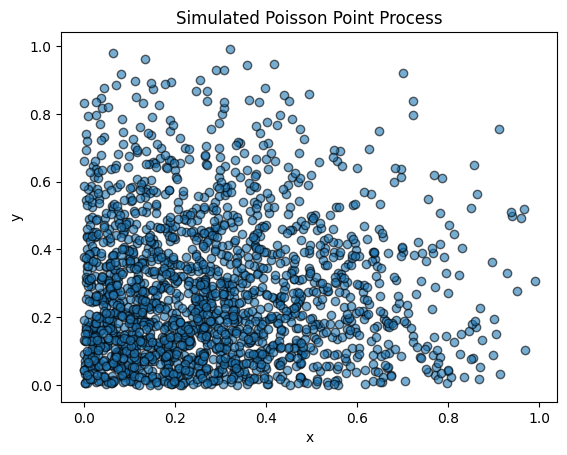

In [6]:
plt.scatter(x_t[:, 0], x_t[:, 1], alpha=0.6, edgecolor='k')
plt.title("Simulated Poisson Point Process")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Poisson Model

In [7]:
class Poisson(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor([np.abs(np.random.randn())], dtype=torch.float32))

    def forward(self, x):
        squared_norm = torch.sum(x**2, dim=-1)
        return - squared_norm / self.scale**2

    def compute_psi(self, x):
        x.requires_grad_()
        nn_output = self.forward(x)
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi

    def loss(self, points):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        x_t = points[:, :lengths.max(), :-1]  # Pad to max length in batch
        
        psi_x = self.compute_psi(x_t)
        norm_squared = (psi_x ** 2).sum(dim=-1)  # Sum across all dimensions
        
        divergence = 0
        for i in range(x_t.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]  # Sum over each feature dimension
        
        total_loss = 0.5 * norm_squared + divergence
        total_loss = total_loss.sum(dim=-1)  # Sum over the time dimension
        
        return total_loss.mean()

In [8]:
def optimize_theta(loader_train, nn_model, num_epochs=1000, learning_rate=1e-3):
    """
    Optimizes the model parameters.

    Args:
        loader_train (DataLoader): DataLoader for training data.
        dim (int): Dimension of input data.
        nn_model (callable): Function that creates the neural network model.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate.

    Returns:
        tuple: (trained model, losses, estimated scales)
    """
    model = nn_model()
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
    losses = []
    estimated_scale = []

    for epoch in range(num_epochs):
        for X_batch in loader_train:
            optimizer.zero_grad()

            loss = model.loss(X_batch[0])

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            estimated_scale.append(model.scale.detach().numpy().copy())
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, estimated_scale


In [9]:
start_time = time.time()
epochs = 100
model, losses, estimated_scale = optimize_theta(
    loader_train, Poisson, num_epochs=epochs, learning_rate=1e-3,
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution Time: {elapsed_time:.2f} seconds")

Epoch 0/100, Loss: -14068.736328125
Epoch 1/100, Loss: -14096.3310546875
Epoch 2/100, Loss: -14129.4873046875
Epoch 3/100, Loss: -14169.3359375
Epoch 4/100, Loss: -14217.2421875
Epoch 5/100, Loss: -14274.8466796875
Epoch 6/100, Loss: -14344.1396484375
Epoch 7/100, Loss: -14427.5146484375
Epoch 8/100, Loss: -14527.87109375
Epoch 9/100, Loss: -14648.6904296875
Epoch 10/100, Loss: -14794.1640625
Epoch 11/100, Loss: -14969.291015625
Epoch 12/100, Loss: -15179.96875
Epoch 13/100, Loss: -15432.98046875
Epoch 14/100, Loss: -15735.7734375
Epoch 15/100, Loss: -16095.650390625
Epoch 16/100, Loss: -16517.61328125
Epoch 17/100, Loss: -16998.884765625
Epoch 18/100, Loss: -17515.134765625
Epoch 19/100, Loss: -17984.345703125
Epoch 20/100, Loss: -18166.26171875
Epoch 21/100, Loss: -18166.26171875
Epoch 22/100, Loss: -18142.69921875
Epoch 23/100, Loss: -18142.69921875
Epoch 24/100, Loss: -18174.001953125
Epoch 25/100, Loss: -18159.48828125
Epoch 26/100, Loss: -18159.48828125
Epoch 27/100, Loss: -18174

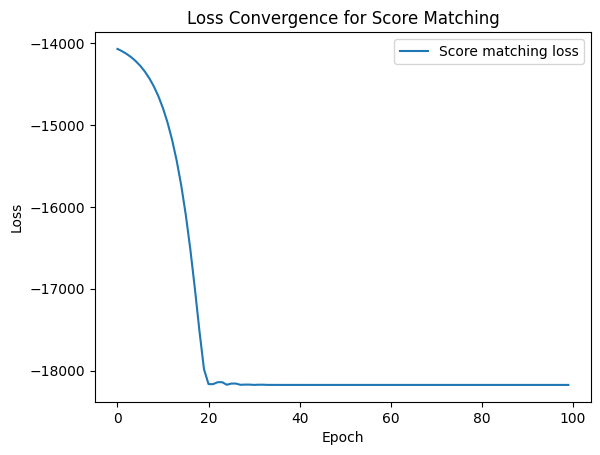

In [10]:
plt.plot(losses, label="Score matching loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()
plt.show()


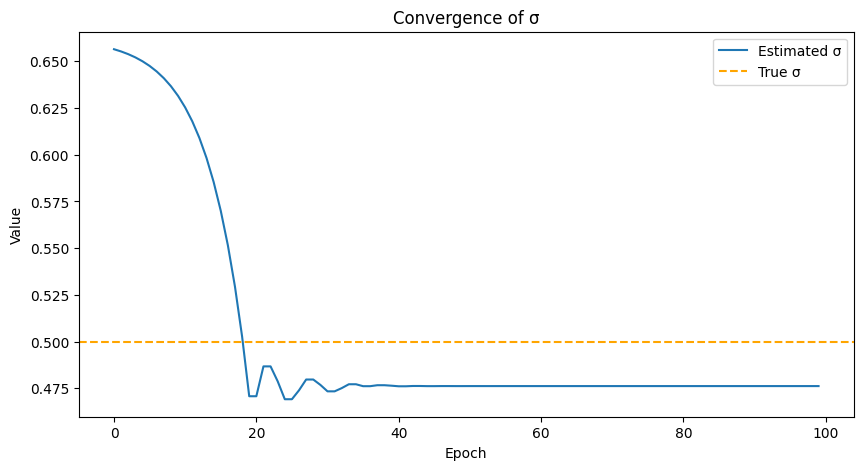

In [11]:
# plt.figure(figsize=(10, 5))
# plt.plot(estimated_kappa, label="Estimated κ")
# plt.axhline(kappa[0], color='orange', linestyle='--', label="True κ")
# plt.xlabel('Epoch')
# plt.ylabel('Value')
# plt.legend()
# plt.title('Convergence of κ')
# plt.show()

plt.figure(figsize=(10, 5))
plt.plot(estimated_scale, label="Estimated σ")
plt.axhline(scale[0], color='orange', linestyle='--', label="True σ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of σ')
plt.show()

In [12]:
# print("Estimated kappa:", model.kappa)
# print("True kappa:", kappa)
print("Estimated scale:", model.scale)
print("True scale:", scale)

Estimated scale: Parameter containing:
tensor([0.4762], requires_grad=True)
True scale: tensor([0.5000])


In [13]:
def infer_kappa(x_t, sigma, region):
    """
    Infers the parameter kappa for the Poisson Point Process intensity function
    given the data x_t and the known scale parameter sigma.
    
    Args:
    - x_t: numpy array of shape (n, d), where n is the number of data points and d is the dimension of the data.
    - sigma: the known scale parameter (positive real number).
    
    Returns:
    - kappa: the inferred scaling factor for the intensity function.
    """
    (a1, b1), (a2, b2) = region
    n = len(x_t)
    
    def integrand(x0, x1, sigma):
        return np.exp(-(x0**2 + x1**2) / sigma**2)

    integral_result, _ = dblquad(integrand, a1, b1, lambda x0: a2, lambda x0: b2, args=(sigma,))
    
    kappa = n / integral_result
    return kappa

In [14]:
kappa = infer_kappa(x_t, estimated_scale[-1][0], region)
print(f"Inferred kappa: {kappa}")

Inferred kappa: 10895.043292283834
